**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2022**

## **Mentoría: Data Science aplicado a BCI**

---
## **Trabajo Práctico 4**
## Introducción al Aprendizaje Supervisado
---

## **Grupo 2**

**Integrantes:** Gastón Briozzo, Pablo Ventura

**Profesor de Práctico:** Juan Manuel Lopez

# **Aprendizaje Supervisado**


# Librerías y Datasets

## Librerías

In [ ]:
from pathlib import Path
from typing import Callable
from scipy import stats
import statistics 
import scipy
import scipy.signal as sgn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

In [ ]:
!wget https://raw.githubusercontent.com/joaco18/MentoriaBCI/main/codigo_notebooks/utils.py
import utils

--2022-10-17 23:36:00--  https://raw.githubusercontent.com/joaco18/MentoriaBCI/main/codigo_notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3639 (3.6K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   3.55K  --.-KB/s    in 0s      

2022-10-17 23:36:00 (66.0 MB/s) - ‘utils.py’ saved [3639/3639]



In [ ]:
!git clone https://github.com/pablogventura/bci_2.git
!mkdir data
!mv bci_2/Database/* data

!mv "data/JA 1 - 2020 - 11-19.txt" "data/JA 1 - 2020-11-19.txt"

Cloning into 'bci_2'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 25 (delta 2), reused 24 (delta 1), pack-reused 0
Unpacking objects: 100% (25/25), done.
Checking out files: 100% (13/13), done.


## BCIDataset

In [ ]:
def filtered_fft_features(signal_matrix):
    N = signal_matrix.shape[1]
    dt = 1/200
    T = N*dt
    sf = 200
    Q = 30
    f_notch = 50
    b_notch, a_notch = sgn.iirnotch(w0=f_notch, Q=Q, fs=sf)
    sig_notch = sgn.filtfilt(b_notch, a_notch, signal_matrix, axis=1)

    #Ahora creamos el filtro pasabanda Butterworth
    f_nq = sf/2
    f_low = 5
    f_high = 40
    order = 4
    b_band, a_band = sgn.iirfilter(
        N=order, Wn=[f_low/f_nq, f_high/f_nq], btype="bandpass", ftype="butter"
    )
    sig_filt = sgn.filtfilt(b_band, a_band, sig_notch, axis=1)

    fft = np.fft.rfft(sig_filt)
    Sxx = np.real(((2*dt**2)/T)*fft*fft.conj())
    return Sxx


def naif_fft_features(signal_matrix):
    N = signal_matrix.shape[1]
    dt = 1/200
    T = N*dt
    fft = np.fft.rfft(signal_matrix)
    Sxx = np.real(((2*dt**2)/T)*fft*fft.conj())
    return Sxx

def calc_statistics(s):
    maxim = np.max(s, axis = 1)[:, np.newaxis]
    minim = np.min(s, axis = 1)[:, np.newaxis]
    mean = np.mean(s, axis = 1)[:, np.newaxis]
    
    mode = scipy.stats.mode(s, axis = 1)[0]
    
    return np.concatenate([maxim, minim, mean, mode], axis = 1)

In [ ]:
def fft_neighbours(signal):
    N = signal.shape[1]
    dt = 1/200
    T = N*dt
    sf = 200
    Q = 30
    f_notch = 50
    b_notch, a_notch = sgn.iirnotch(w0=f_notch, Q=Q, fs=sf)
    sig_notch = sgn.filtfilt(b_notch, a_notch, signal, axis=1)

    #Ahora creamos el filtro pasabanda Butterworth
    f_nq = sf/2
    f_low = 5
    f_high = 40
    order = 4
    b_band, a_band = sgn.iirfilter(
        N=order, Wn=[f_low/f_nq, f_high/f_nq], btype="bandpass", ftype="butter"
    )
    sig_filt = sgn.filtfilt(b_band, a_band, sig_notch, axis=1)
    
    frq = np.fft.rfftfreq(N, dt)
    tf = abs(np.fft.rfft(sig_filt, axis = 1))
    
    #Interest Frequencies:
    interest_frq = [12.5, 16.5]
    harmonics = True
    bandwidth = 1.0
    
    mask = []
    selected_frq = []
    
    for f in frq:
        if any([int_f - bandwidth < f < int_f + bandwidth for int_f in interest_frq]):
            mask.append(True)
            selected_frq.append(f)
        elif harmonics and any([2*int_f - bandwidth < f < 2*int_f + bandwidth for int_f in interest_frq]):
            mask.append(True)
            selected_frq.append(f)
        else:
            mask.append(False)
        
    #print(selected_frq)
    
    return tf[:, mask]

In [ ]:
class BCIDataset():
    def __init__(
        self, 
        csvs_path, 
        subject: str = 'all', 
        session: str = 'all',
        channel: str = 'all', 
        overlapping_fraction: float = 1/3, 
        window_size: int = 900,
        feature_extractor: Callable = naif_fft_features
    ):
        '''
        Object containing all examples from a time series from the dataset.
        Args:
            csvs_path (str): path al directorio donde estan los csv de los datos
            subject (str): sujeto a estudiar.
                Si se indica 'all' el dataset final generado tendrá ejemplos de todos los sujetos
            session (str): sesión a estudiar del sujeto seleccionado.
                si se indica 'all'  el dataset final generado tendrá ejemplos de todas las sesiones
            channel (str): 'ch0', 'ch1', 'ch2', 'ch3'. Si se indica 'all', los ejemplos serán la
                concatenación de los 4 canales.
            overlapping_fraction (float): porcentaje de desplazamiento de la "ventana" que hace el ejemplo
            window_size (int): tamaño de la ventana de tiempo que hace a un ejemplo (en muestras).
            feature_extractor (func): Función de extracción de features, le ingresa un arreglo
                (ejemplos en las filas, muestras en las columnas) y devuelve un arreglo (ejemplos en
                las filas y features en las columnas)
        '''
        self.csvs_path = Path(csvs_path)
        self.channel = channel
        self.parts = int(1 / overlapping_fraction)
        self.fraction = 1 / self.parts
        self.ws = window_size
        self.subject = subject
        self.session = session
        self.channels = ['ch0','ch1','ch2','ch3']
        self.feature_extractor = feature_extractor
        self.complete_dataset = utils.read_all_datasets(self.csvs_path)
        
        self.complete_examples_signal, self.complete_examples_features, self.complete_labels, self.complete_metadata = self.generate_examples()
        
    def generate_examples(self):
        # For each session generate the signal examples,
        # the feature extraction examples and labels arrays
        complete_examples_signal, complete_examples_features = [], []
        complete_labels, complete_metadata = [], []
        
        for subject in self.complete_dataset.subject.unique():
            # Just load the selected subject
            if self.subject != 'all' and subject != self.subject:
                continue
            sessions = \
                self.complete_dataset.loc[self.complete_dataset.subject==subject].session.unique()
            for session in sessions:
                # Just load the selected session
                if self.session != 'all' and session != self.session:
                    continue
                
                print(f'Processing subject: {subject} - session: {session}...')
                
                # Generate a subset of the dataset only with the desired rows
                selection = self.complete_dataset.loc[
                    (self.complete_dataset.subject==subject) &
                    (self.complete_dataset.session==session)
                ]
                
                # Standarize length of the array to a multiple to window size
                labels = selection.label.values
                n_rows = labels.shape[0] // self.ws
                labels = labels[: n_rows * self.ws]

                # Generate examples from the signal
                n_examples = n_rows * self.parts - (self.parts - 1)
                examples = np.empty((n_examples, self.ws))
                most_frec_labels = np.empty((n_examples, self.ws))
                times = np.empty((n_examples, self.ws))
                
                concat_ch_examples_signal, concat_ch_examples_features = [], []

                for k, ch in enumerate(self.channels):
                    # Use the four channels or just one
                    if self.channel != 'all' and self.channel != ch:
                        continue
                    
                    # Standarize length of the signal to a multiple to window size
                    signal = selection[ch].values
                    signal = signal[: n_rows * self.ws]
                    time = selection.time.values
                    time = time[: n_rows * self.ws]

                    # Increase the number of examples by overlapping the windows
                    for part in range(self.parts):
                        
                        # Find the place in the output array for each example
                        position = np.arange(part, n_examples, self.parts)
                        #position = position if part == 0 else position[:-part]

                        # Crop the signal according to the window size and overlap
                        start = int(self.ws / self.parts) * part
                        end = -int(self.ws - (self.ws / self.parts) * part)
                        end = end if part!=0 else signal.shape[0]
                        subset_signal = signal[start:end]
                        subset_labels = labels[start:end]
                        subset_times = time[start:end]

                        # Generate the examples
                        n_rows_ = int(subset_signal.shape[0]/self.ws)
                        examples[position, :] = subset_signal.reshape((n_rows_, self.ws))
                        most_frec_labels[position, :] = subset_labels.reshape((n_rows_, self.ws))
                        times[position, :] = subset_times.reshape((n_rows_, self.ws))
                    
                    # Obtain most frequent label
                    labels_ = scipy.stats.mode(most_frec_labels, axis=1).mode
                    labels_temp = scipy.stats.mode(most_frec_labels, axis=1).count
                    pureness = labels_temp == self.ws
                    # Get first and last time of the window
                    times_ = np.asarray([np.min(times, axis=1), np.max(times, axis=1)]).T
                    # Extract features
                    features = self.feature_extractor(examples)
                    freqs = np.fft.rfft(examples)
                    

                    concat_ch_examples_signal.append(examples.copy())
                    concat_ch_examples_features.append(features)

                concat_ch_examples_signal = np.concatenate(concat_ch_examples_signal, axis=1)
                concat_ch_examples_features = np.concatenate(concat_ch_examples_features, axis=1)

                complete_examples_signal.append(concat_ch_examples_signal)
                complete_examples_features.append(concat_ch_examples_features)
                complete_labels.append(labels_)
                lt = len(times_)
                metadata_ = np.concatenate(
                    [pureness, times_, np.repeat(subject, lt)[:,None], np.repeat(session, lt)[:,None]],
                    axis=1
                )
                complete_metadata.append(metadata_)

        complete_examples_signal = np.concatenate(complete_examples_signal)
        complete_examples_features = np.concatenate(complete_examples_features)
        complete_labels = np.concatenate(complete_labels)
        complete_metadata = np.concatenate(complete_metadata)
        
        return complete_examples_signal, complete_examples_features, complete_labels, complete_metadata
    
    def __len__(self):
        return self.complete_examples_signal.shape[0]
    
    def __getitem__(self, idx):
        return {
            'signal': self.complete_examples_signal[idx,:],
            'features': self.complete_examples_features[idx,:],
            'label': self.complete_labels[idx,:],
            'metadata': self.complete_metadata[idx,:]
        }

    def get_X_signal(self):
        return self.complete_examples_signal

    def get_X_features(self):
        return self.complete_examples_features

    def get_Y(self):
        return self.complete_labels

    def get_metadata(self):
        return self.complete_metadata

##Features

In [ ]:
def signal_filter(signal_matrix):

    for i in range(len(signal_matrix)):
        signal_matrix[i] = ( signal_matrix[i] - np.mean(signal_matrix[i]) )  / np.std(signal_matrix[i])

    N = signal_matrix.shape[1]
    dt = 1/200
    T = N*dt
    sf = 200
    Q = 30
    f_notch = 50
    b_notch, a_notch = sgn.iirnotch(w0=f_notch, Q=Q, fs=sf)
    sig_notch = sgn.filtfilt(b_notch, a_notch, signal_matrix, axis=1)

    #Ahora creamos el filtro pasabanda Butterworth
    f_nq = sf/2
    f_low = 10
    f_high = 19
    order = 4
    b_band, a_band = sgn.iirfilter(
        N=order, Wn=[f_low/f_nq, f_high/f_nq], btype="bandpass", ftype="butter"
    )
    sig_filt = sgn.filtfilt(b_band, a_band, sig_notch, axis=1)

    fft = np.fft.rfft(sig_filt)
    Sxx = np.real(((2*dt**2)/T)*fft*fft.conj())   

    #for i in range(len(Sxx)):
    #    Sxx[i] = ( Sxx[i] - np.mean(Sxx[i]) )  / np.std(Sxx[i])

    return Sxx

In [ ]:
def max_freq(signal_matrix):

    N = signal_matrix.shape[1]
    dt = 1/200

    Sxx = signal_filter(signal_matrix) 
    freqs = np.fft.rfftfreq(n=N, d=dt)

    freqs = np.fft.rfftfreq(n=N, d=dt)
    fmax = freqs[Sxx.argmax()]

    return fmax

In [ ]:
def p_freq(Sxx,freqs):

    p_125 = 0
    p_165 = 0
    p     = 0

    fmax = freqs[Sxx.argmax()]
    m    = np.mean(Sxx)

    for i in range(len(freqs)):
      f = freqs[i]
      s = Sxx[i]
      p_125 += s*math.exp( -2 * (12.5-f)**2 )
      p_165 += s*math.exp( -2 * (16.5-f)**2 )
      p     += m*math.exp( -2 * (fmax-f)**2 )

   # p = p_125 + p_165
    p_125 = p_125/p
    p_165 = p_165/p

    return p_125, p_165

In [ ]:
def v_freq(Sxx,freqs):

    v_125 = 0
    v_165 = 0
    v_max = 0

    for i in range(len(freqs)-1):
        f  = freqs[i]
        s  = Sxx[i]
        fn = freqs[i+1]
        sn = Sxx  [i+1]
        if (f == 12.5):
            v_125 = s
        if (f<12.5 and 12.5<fn):
            v_125 = ( (fn-12.5)*s + (12.5-f)*sn ) / (fn - f)
        if (f == 16.5):
            v_165 = s
        if (f<16.5 and 16.5<fn):
            v_165 = ( (fn-16.5)*s + (16.5-f)*sn ) / (fn - f)

    v_max = max(Sxx)

    v_125 = v_125/v_max
    v_165 = v_165/v_max

    return v_125, v_165

In [ ]:
def pro_features(signal_matrix):

    N = signal_matrix.shape[1]
    dt = 1/200

    Sxx = signal_filter(signal_matrix) 
    freqs = np.fft.rfftfreq(n=N, d=dt)

    vpm = []

    for sxx in Sxx:
        fmax = freqs[sxx.argmax()]
        p_125, p_165 = p_freq(sxx,freqs)
        v_125, v_165 = v_freq(sxx,freqs)

        vpm.append([v_125, v_165, p_125, p_165, fmax])    

    return vpm

## Guardado

In [ ]:
def ds_to_csv(ds,path):
  df = pd.DataFrame(data=np.hstack((ds.get_X_features(),ds.get_metadata(),ds.get_Y())),
                      index=None,
                      columns=["val_12.5_ch0", "val_16.5_ch0", "p_12.5_ch0", "p_16.5_ch0", "f_max_ch0",
                               "val_12.5_ch1", "val_16.5_ch1", "p_12.5_ch1", "p_16.5_ch1", "f_max_ch1",
                               "val_12.5_ch2", "val_16.5_ch2", "p_12.5_ch2", "p_16.5_ch2", "f_max_ch2",
                               "val_12.5_ch3", "val_16.5_ch3", "p_12.5_ch3", "p_16.5_ch3", "f_max_ch3",
                               "pureza", "tiempo0", "tiempof", "sujeto", "sesion",
                               "label"]
                      )
  objects = {"pureza", "tiempo0", "tiempof", "sujeto", "sesion"}
  convert_dict=dict()
  for k in df.columns:
    if k not in objects:
      convert_dict[k] = float
    else:
      convert_dict[k] = object

  df = df.astype(convert_dict)

  df.to_csv(path)
  return df

## Dataset, Conjuntos de Train y Test

In [ ]:
csvs_path = 'data'

In [ ]:
data_all = BCIDataset(csvs_path, overlapping_fraction=1/4, window_size= 1240, feature_extractor=pro_features)

Processing subject: AA - session: 0...
Processing subject: AA - session: 1...
Processing subject: AA - session: 2...
Processing subject: JA - session: 1...
Processing subject: JA - session: 2...
Processing subject: MA - session: 1...
Processing subject: HA - session: 1...


In [ ]:
data = np.hstack((data_all.get_X_features(), data_all.get_Y()))

In [ ]:
data_cleaned = data[data[:,-1]!=99]

In [ ]:
from sklearn.model_selection import train_test_split
X, y = data_cleaned[:,:-1],data_cleaned[:,-1]
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, random_state=0)
X_test, X_val, y_test, y_val = train_test_split(X_rem, y_rem, train_size=0.5, random_state=0)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

#X_train

((659, 20), (82, 20), (83, 20), (659,), (82,), (83,))

In [ ]:
for d in [y_train,y_test,y_val]:
  print(np.unique(d, return_counts=True))

(array([1., 2.]), array([320, 339]))
(array([1., 2.]), array([41, 41]))
(array([1., 2.]), array([37, 46]))


In [ ]:
X_train

array([[ 0.3317262 ,  0.06496253, 12.3146278 , ..., 12.09666985,
         7.75106029, 10.96774194],
       [ 0.50316962,  0.05098278, 14.46340581, ..., 14.31051903,
         8.09296694, 12.41935484],
       [ 0.07877487,  0.06045199, 14.58132509, ..., 15.63970616,
         9.17964014, 17.25806452],
       ...,
       [ 0.08392727,  0.04704488,  8.30293636, ..., 10.14124338,
        18.32179977, 16.77419355],
       [ 0.72094088,  0.06495657, 18.23666554, ..., 29.85880794,
         5.6381833 , 12.58064516],
       [ 0.40846289,  0.14168306, 14.96400329, ..., 16.96998101,
        12.21146051, 12.41935484]])

In [ ]:
def to_numerical(vector):
  result = vector.copy()
  result[result == 99] = 0
  result[result == 1] = -1
  result[result == 2] = 1
  return result

In [ ]:
y_train_e = to_numerical(y_train)
y_test_e = to_numerical(y_test)
y_val_e = to_numerical(y_val)

# A) Benchmarking y desarrollo del algoritmo evaluador:


##a) Utilice una clasificación aleatoria de los ejemplos para utilizar como benchmark de los resultados posteriores. Este benchmark representa el peor de los desempeños de clasificación posibles.


Emplearemos el clasificador aleatorio DummyClassifier de sklearn como benchmark en orden de sentar una base para la mínima presición aceptable.

Dado que las clases estan bien balanceadas, la accuracy será métrica suficiente.


In [ ]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy='uniform')
dummy_clf.fit(X_train, y_train)


DummyClassifier(strategy='uniform')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


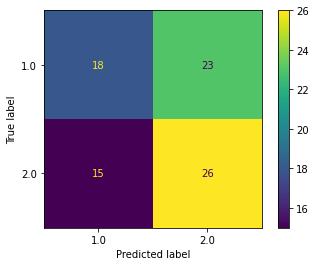

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
plot_confusion_matrix(dummy_clf,X_test,y_test)
plt.show()

In [ ]:
y_pred = dummy_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.46      0.39      0.42        41
         2.0       0.47      0.54      0.50        41

    accuracy                           0.46        82
   macro avg       0.46      0.46      0.46        82
weighted avg       0.46      0.46      0.46        82



##b) Evalúe el desempeño/rendimiento de este benchmark bajo las métricas seleccionadas en el apartado anterior. Considere repetir este procedimiento algunas veces para obtener un promedio, máximo, mínimo u otro representante de estos resultados, ya que se trata de un proceso completamente aleatorio.


Haremos una descripción estadística de la presición del clasificador aleatorio

In [ ]:
from sklearn.metrics import accuracy_score

accu_stat = []

for i in range(100):
    y_pred = dummy_clf.predict(X_test)
    accu_stat.append(accuracy_score(y_test, y_pred))

print("Accuracy Mean Value:", statistics.mean(accu_stat))
print("Accuracy Min  Value:", min(accu_stat))
print("Accuracy Max  Value:", max(accu_stat))
print("Accuracy StaD Value:", statistics.stdev(accu_stat))

Accuracy Mean Value: 0.5007317073170732
Accuracy Min  Value: 0.34146341463414637
Accuracy Max  Value: 0.6585365853658537
Accuracy StaD Value: 0.05456082522380473


Vemos que la accuracy promedio del clasificador aleatorio esta en torno al $50\%$, lo que es de esperarse en un problema binomial equilibrado.

#B) Búsqueda a grandes rasgos:


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    scoring : str or callable, default=None
        A str (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Ejemplos de entrenamiento")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Ejemplos de entrenamiento")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Escalabilidad del modelo")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

##a) Utilicen la mayor cantidad de algoritmos de aprendizaje automático supervisado que puedan (mínimo 3). Creen para cada uno un modelo bajo el paradigma de dicho método y entrénelo con el dataset elegido. Opcional: generar curvas de progreso de métricas y funciones de pérdida a lo largo del entrenamiento.


In [ ]:
def get_ttv(ovfr,wisi):
    data_all = BCIDataset(csvs_path, overlapping_fraction=ovfr, window_size= wisi, feature_extractor=pro_features)
    data = np.hstack((data_all.get_X_features(), data_all.get_Y()))
    data_cleaned = data[data[:,-1]!=99]
    X, y = data_cleaned[:,:-1],data_cleaned[:,-1]
    X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, random_state=0)
    X_test, X_val, y_test, y_val = train_test_split(X_rem, y_rem, train_size=0.5, random_state=0)
    y_train_e = to_numerical(y_train)
    y_test_e = to_numerical(y_test)
    y_val_e = to_numerical(y_val)

    return X_train, X_test, X_val, y_train, y_test, y_val

### K-means

In [ ]:
from sklearn.cluster import KMeans
#kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train)
#kmeans.cluster_centers_

In [ ]:
def class_kmeans(algorithm, ovfr, wisi):
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))
    X_train, X_test, X_val, y_train, y_test, y_val = get_ttv(ovfr,wisi)
    #kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=0, copy_x=True, algorithm=algorithm).fit(X_train)
    kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=0, copy_x=True, algorithm=algorithm)
    plot_learning_curve(kmeans,"kmeans",X_train,y_train,axes=axes,ylim=None,cv=None,
                        n_jobs=None,scoring=None,train_sizes=np.linspace(0.1, 1.0, 5))
    kmeans.fit(X_train,y_train)
    # algorithm{“lloyd”, “elkan”, “auto”, “full”            
    plt.show()
    return kmeans

Processing subject: AA - session: 0...
Processing subject: AA - session: 1...
Processing subject: AA - session: 2...
Processing subject: JA - session: 1...
Processing subject: JA - session: 2...
Processing subject: MA - session: 1...
Processing subject: HA - session: 1...


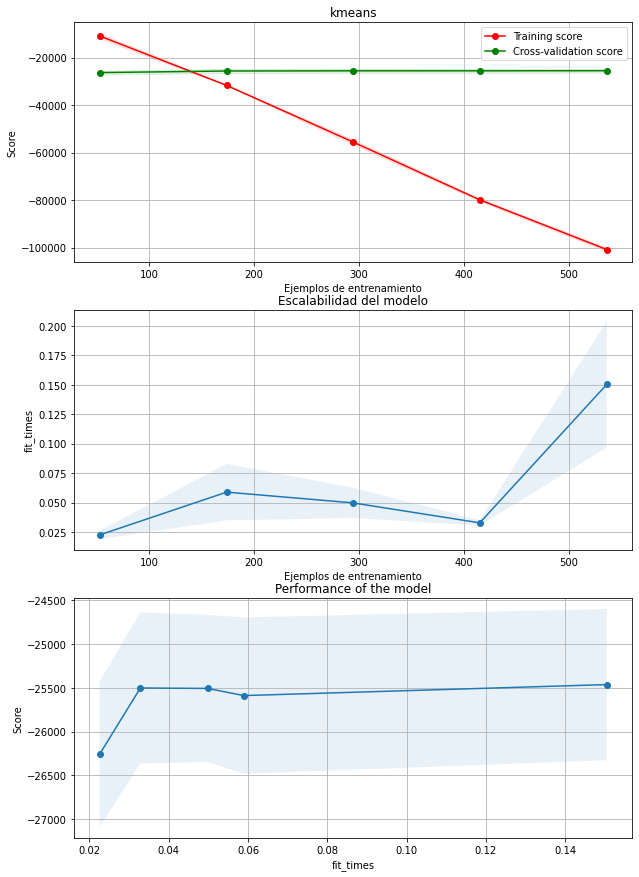

Algorithm:  elkan  Accuracy:  0.7317073170731707
Processing subject: AA - session: 0...
Processing subject: AA - session: 1...
Processing subject: AA - session: 2...
Processing subject: JA - session: 1...
Processing subject: JA - session: 2...
Processing subject: MA - session: 1...
Processing subject: HA - session: 1...


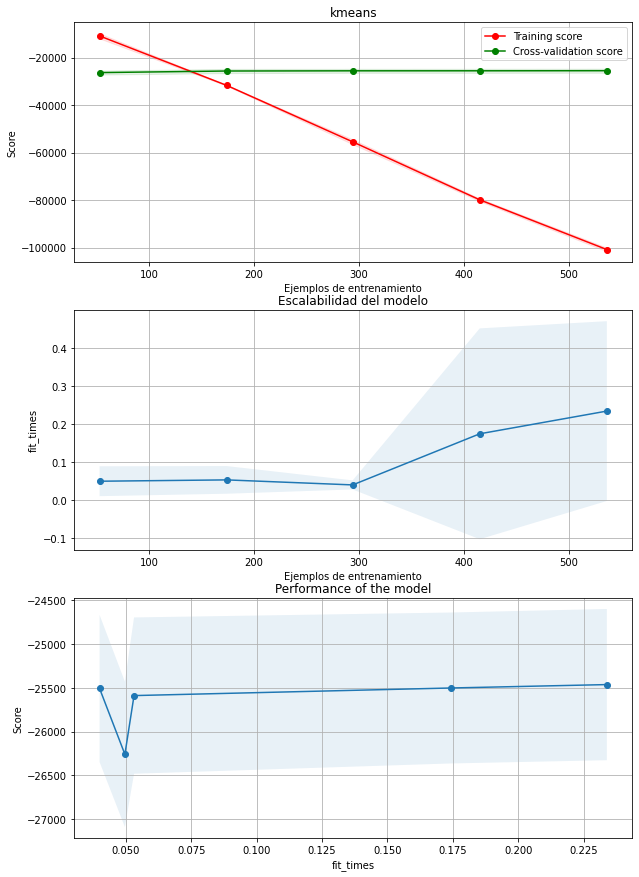

Algorithm:  auto  Accuracy:  0.7317073170731707
Processing subject: AA - session: 0...
Processing subject: AA - session: 1...
Processing subject: AA - session: 2...
Processing subject: JA - session: 1...
Processing subject: JA - session: 2...
Processing subject: MA - session: 1...
Processing subject: HA - session: 1...


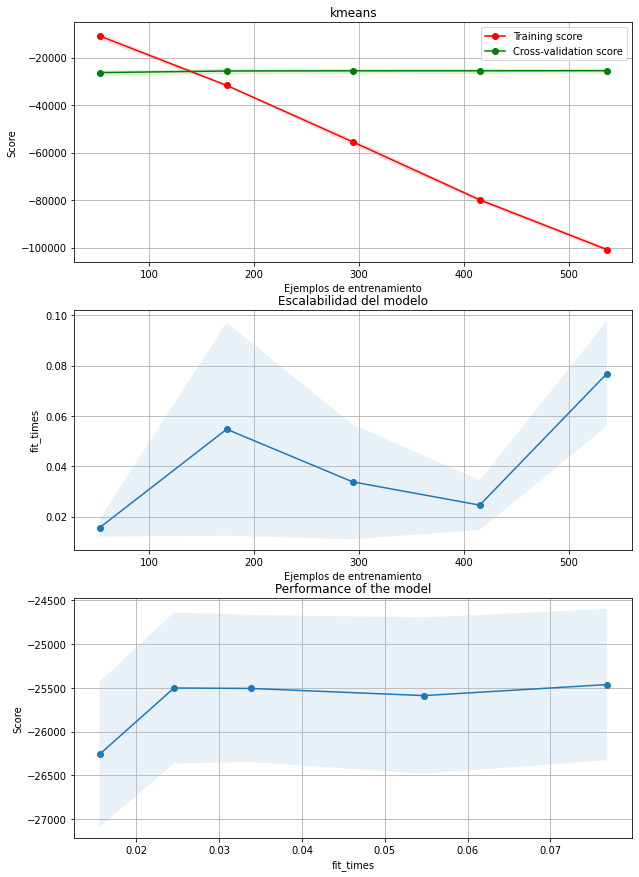

Algorithm:  full  Accuracy:  0.7317073170731707


In [ ]:
algorithms = ['elkan', 'auto', 'full']   

for algorithm in algorithms:
    kmeans = class_kmeans(algorithm, 1/4, 1200)
    
    y_pred = (1-kmeans.predict(X_test)) + 1 # las clases son 0 y 1 originalmente
    acc = accuracy_score(y_test, y_pred)
    print('Algorithm: ', algorithm, ' Accuracy: ', acc)

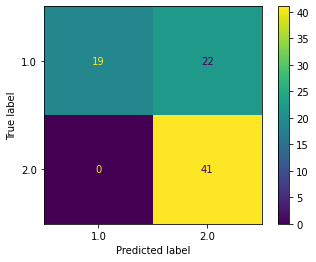

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
y_pred = (1-kmeans.predict(X_test)) + 1 # las clases son 0 y 1 originalmente
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       1.00      0.46      0.63        41
         2.0       0.65      1.00      0.79        41

    accuracy                           0.73        82
   macro avg       0.83      0.73      0.71        82
weighted avg       0.83      0.73      0.71        82



### Random Forest GBDT

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
def class_RF_GBDT(n_e, lr, ovfr, wisi):
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))
    X_train, X_test, X_val, y_train, y_test, y_val = get_ttv(ovfr,wisi)
    gb_clf2 = GradientBoostingClassifier(n_estimators=n_e, learning_rate=lr, max_features=2, max_depth=2, random_state=0)

    plot_learning_curve(gb_clf2,"gb_clf2",X_train,y_train,axes=axes,ylim=None,cv=None,
                        n_jobs=None,scoring=None,train_sizes=np.linspace(0.1, 1.0, 5))
    gb_clf2.fit(X_train, y_train)       
    plt.show()
    return gb_clf2

Processing subject: AA - session: 0...
Processing subject: AA - session: 1...
Processing subject: AA - session: 2...
Processing subject: JA - session: 1...
Processing subject: JA - session: 2...
Processing subject: MA - session: 1...
Processing subject: HA - session: 1...


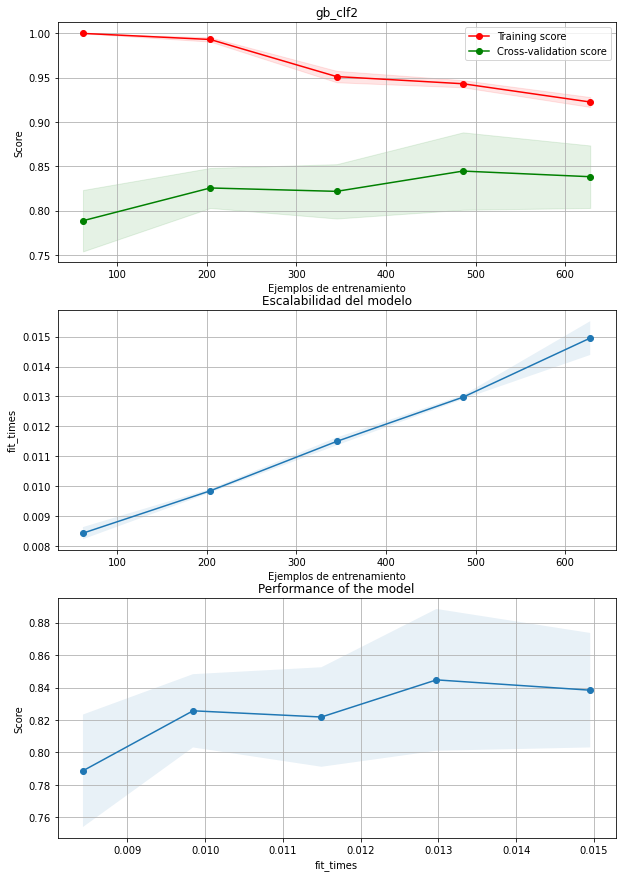

In [ ]:
gb_clf2 = class_RF_GBDT(20, 0.5, 1/4, 1024)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


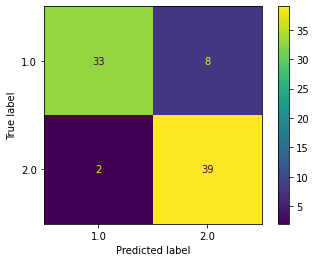

In [ ]:
plot_confusion_matrix(gb_clf2,X_test,y_test)
plt.show()

In [ ]:
y_pred = gb_clf2.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.94      0.80      0.87        41
         2.0       0.83      0.95      0.89        41

    accuracy                           0.88        82
   macro avg       0.89      0.88      0.88        82
weighted avg       0.89      0.88      0.88        82



### LinearSVC

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
def class_LinearSVC(ovfr, wisi):
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))
    X_train, X_test, X_val, y_train, y_test, y_val = get_ttv(ovfr,wisi)
    clf = make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-5))
    plot_learning_curve(clf,"gb_clf2",X_train,y_train,axes=axes,ylim=None,cv=None,
                    n_jobs=None,scoring=None,train_sizes=np.linspace(0.1, 1.0, 5))
    clf.fit(X_train, y_train)       
    plt.show()
    return clf

Processing subject: AA - session: 0...
Processing subject: AA - session: 1...
Processing subject: AA - session: 2...
Processing subject: JA - session: 1...
Processing subject: JA - session: 2...
Processing subject: MA - session: 1...
Processing subject: HA - session: 1...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


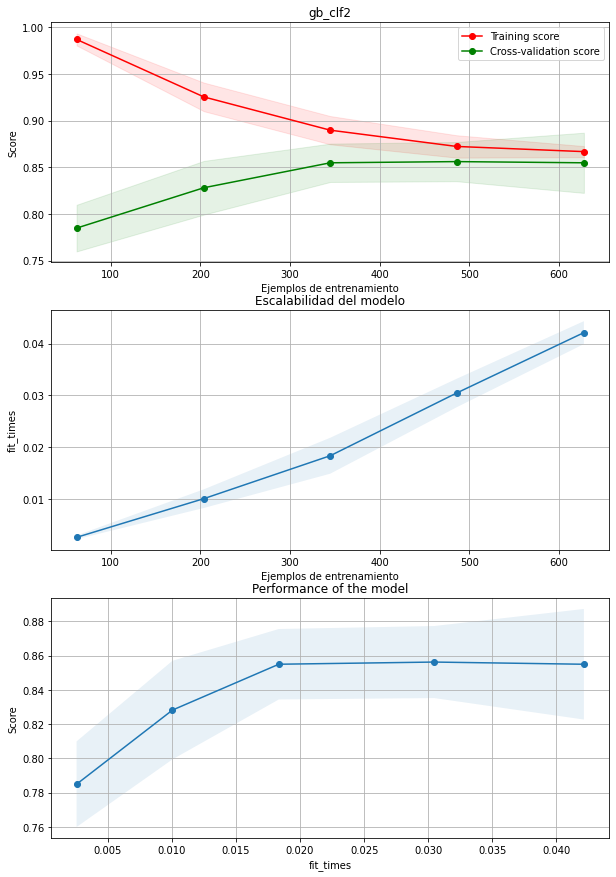

In [ ]:
clf = class_LinearSVC(1/4, 1024)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


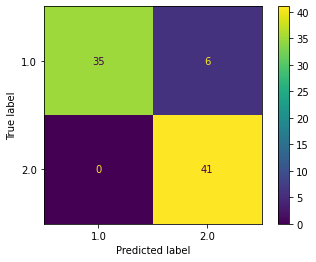

In [ ]:
plot_confusion_matrix(clf,X_test,y_test)
plt.show()

In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       1.00      0.85      0.92        41
         2.0       0.87      1.00      0.93        41

    accuracy                           0.93        82
   macro avg       0.94      0.93      0.93        82
weighted avg       0.94      0.93      0.93        82



##b) No hace falta que la búsqueda de hiperparámetros sea extremadamente detallada, ya que esto se llevará a cabo en el inciso C), sino más bien una exploración general de las tendencias de cada modelo.


##c) Si encuentra resultados de las métricas analizadas o gráficos de entrenamiento ploteados que resulten destacables -no sólo porque sean valores más óptimos, sino también posibles casos extraños, situaciones de over y underfitting, etc- muéstrelos y analícelos en este inciso.


En particular la curva de aprendizaje de kmeans resulta dificilmente interpretable presentando valores sumamente negativos probablemente debido al hecho de que el algoritmo no sea adecuado para el problema.

#C) Búsqueda puntualizada:


##a) Con el modelo que presente mejores resultados, lleve a cabo una búsqueda ahora sí más detallista, variando los hiperparámetros y funciones de costo. Si estos métodos permiten variar la cantidad de instancias/épocas de entrenamiento, analice lo que sucede cuando varía las duraciones de entrenamiento.


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
                "linearsvc__loss"             : ["hinge", "squared_hinge"],
                'linearsvc__C'                : [0.1, 1, 10],
                'linearsvc__intercept_scaling': [0.1, 1, 10]
             }

window_sizes = [1024, 1200, 1240, 1300]
overlapping_fractions = [1/2, 1/4, 1/8]

In [ ]:
clf = make_pipeline(StandardScaler(),LinearSVC(max_iter=100000, random_state=0, tol=1e-5))

In [ ]:
clf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'linearsvc', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'linearsvc__C', 'linearsvc__class_weight', 'linearsvc__dual', 'linearsvc__fit_intercept', 'linearsvc__intercept_scaling', 'linearsvc__loss', 'linearsvc__max_iter', 'linearsvc__multi_class', 'linearsvc__penalty', 'linearsvc__random_state', 'linearsvc__tol', 'linearsvc__verbose'])

In [ ]:
the_best_model=None
the_best_accuracy=0
for wisi in window_sizes:
    for ovfr in overlapping_fractions:

        if(wisi==1300 and ovfr==1/8):
         continue

        X_train, X_test, X_val, y_train, y_test, y_val = get_ttv(ovfr,wisi)

        gs = GridSearchCV(clf, param_grid)#, cv=5)# refit="AUC",  n_jobs=2, return_train_score=True,)
        gs.fit(X_train, y_train)

        best_model = gs.best_estimator_

        y_pred = best_model.predict(X_test)
        acs    =  accuracy_score(y_test,y_pred)
        if acs > the_best_accuracy:
          the_best_model = best_model
          the_best_accuracy = acs

        print("Window Size: ", wisi, " Overlaping Fraction: ", ovfr, " Best Accuracy: ", acs)
        print('Mejor Estimador', gs.best_estimator_)

Processing subject: AA - session: 0...
Processing subject: AA - session: 1...
Processing subject: AA - session: 2...
Processing subject: JA - session: 1...
Processing subject: JA - session: 2...
Processing subject: MA - session: 1...
Processing subject: HA - session: 1...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Window Size:  1024  Overlaping Fraction:  0.5  Best Accuracy:  0.86
Mejor Estimador Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=0.1, max_iter=100000, random_state=0, tol=1e-05))])
Processing subject: AA - session: 0...
Processing subject: AA - session: 1...
Processing subject: AA - session: 2...
Processing subject: JA - session: 1...
Processing subject: JA - session: 2...
Processing subject: MA - session: 1...
Processing subject: HA - session: 1...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

Window Size:  1024  Overlaping Fraction:  0.25  Best Accuracy:  0.8163265306122449
Mejor Estimador Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=0.1, intercept_scaling=0.1, max_iter=100000,
                           random_state=0, tol=1e-05))])
Processing subject: AA - session: 0...
Processing subject: AA - session: 1...
Processing subject: AA - session: 2...
Processing subject: JA - session: 1...
Processing subject: JA - session: 2...
Processing subject: MA - session: 1...
Processing subject: HA - session: 1...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

Window Size:  1024  Overlaping Fraction:  0.125  Best Accuracy:  0.8163265306122449
Mejor Estimador Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=10, intercept_scaling=10, loss='hinge',
                           max_iter=100000, random_state=0, tol=1e-05))])
Processing subject: AA - session: 0...
Processing subject: AA - session: 1...
Processing subject: AA - session: 2...
Processing subject: JA - session: 1...
Processing subject: JA - session: 2...
Processing subject: MA - session: 1...
Processing subject: HA - session: 1...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

Window Size:  1200  Overlaping Fraction:  0.5  Best Accuracy:  0.8809523809523809
Mejor Estimador Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=1, loss='hinge', max_iter=100000, random_state=0,
                           tol=1e-05))])
Processing subject: AA - session: 0...
Processing subject: AA - session: 1...
Processing subject: AA - session: 2...
Processing subject: JA - session: 1...
Processing subject: JA - session: 2...
Processing subject: MA - session: 1...
Processing subject: HA - session: 1...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

Window Size:  1200  Overlaping Fraction:  0.25  Best Accuracy:  0.9047619047619048
Mejor Estimador Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=10, intercept_scaling=0.1, loss='hinge',
                           max_iter=100000, random_state=0, tol=1e-05))])
Processing subject: AA - session: 0...
Processing subject: AA - session: 1...
Processing subject: AA - session: 2...
Processing subject: JA - session: 1...
Processing subject: JA - session: 2...
Processing subject: MA - session: 1...
Processing subject: HA - session: 1...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

Window Size:  1200  Overlaping Fraction:  0.125  Best Accuracy:  0.8154761904761905
Mejor Estimador Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=0.1, loss='hinge', max_iter=100000, random_state=0,
                           tol=1e-05))])
Processing subject: AA - session: 0...
Processing subject: AA - session: 1...
Processing subject: AA - session: 2...
Processing subject: JA - session: 1...
Processing subject: JA - session: 2...
Processing subject: MA - session: 1...
Processing subject: HA - session: 1...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Window Size:  1240  Overlaping Fraction:  0.5  Best Accuracy:  0.9
Mejor Estimador Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=0.1, intercept_scaling=0.1, max_iter=100000,
                           random_state=0, tol=1e-05))])
Processing subject: AA - session: 0...
Processing subject: AA - session: 1...
Processing subject: AA - session: 2...
Processing subject: JA - session: 1...
Processing subject: JA - session: 2...
Processing subject: MA - session: 1...
Processing subject: HA - session: 1...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

Window Size:  1240  Overlaping Fraction:  0.25  Best Accuracy:  0.9390243902439024
Mejor Estimador Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=1, intercept_scaling=0.1, loss='hinge',
                           max_iter=100000, random_state=0, tol=1e-05))])
Processing subject: AA - session: 0...
Processing subject: AA - session: 1...
Processing subject: AA - session: 2...
Processing subject: JA - session: 1...
Processing subject: JA - session: 2...
Processing subject: MA - session: 1...
Processing subject: HA - session: 1...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

Window Size:  1240  Overlaping Fraction:  0.125  Best Accuracy:  0.8536585365853658
Mejor Estimador Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=1, intercept_scaling=0.1, loss='hinge',
                           max_iter=100000, random_state=0, tol=1e-05))])
Processing subject: AA - session: 0...
Processing subject: AA - session: 1...
Processing subject: AA - session: 2...
Processing subject: JA - session: 1...
Processing subject: JA - session: 2...
Processing subject: MA - session: 1...
Processing subject: HA - session: 1...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Window Size:  1300  Overlaping Fraction:  0.5  Best Accuracy:  0.8421052631578947
Mejor Estimador Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=0.1, intercept_scaling=0.1, loss='hinge',
                           max_iter=100000, random_state=0, tol=1e-05))])
Processing subject: AA - session: 0...
Processing subject: AA - session: 1...
Processing subject: AA - session: 2...
Processing subject: JA - session: 1...
Processing subject: JA - session: 2...
Processing subject: MA - session: 1...
Processing subject: HA - session: 1...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

Window Size:  1300  Overlaping Fraction:  0.25  Best Accuracy:  0.8701298701298701
Mejor Estimador Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=0.1, intercept_scaling=0.1, max_iter=100000,
                           random_state=0, tol=1e-05))])


In [ ]:
the_best_model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=1, intercept_scaling=0.1, loss='hinge',
                           max_iter=100000, random_state=0, tol=1e-05))])

##b) Reporte los resultados obtenidos y seleccione el set completo de configuraciones que mejor resuelven, bajo su criterio, nuestro problema de clasificación

Processing subject: AA - session: 0...
Processing subject: AA - session: 1...
Processing subject: AA - session: 2...
Processing subject: JA - session: 1...
Processing subject: JA - session: 2...
Processing subject: MA - session: 1...
Processing subject: HA - session: 1...


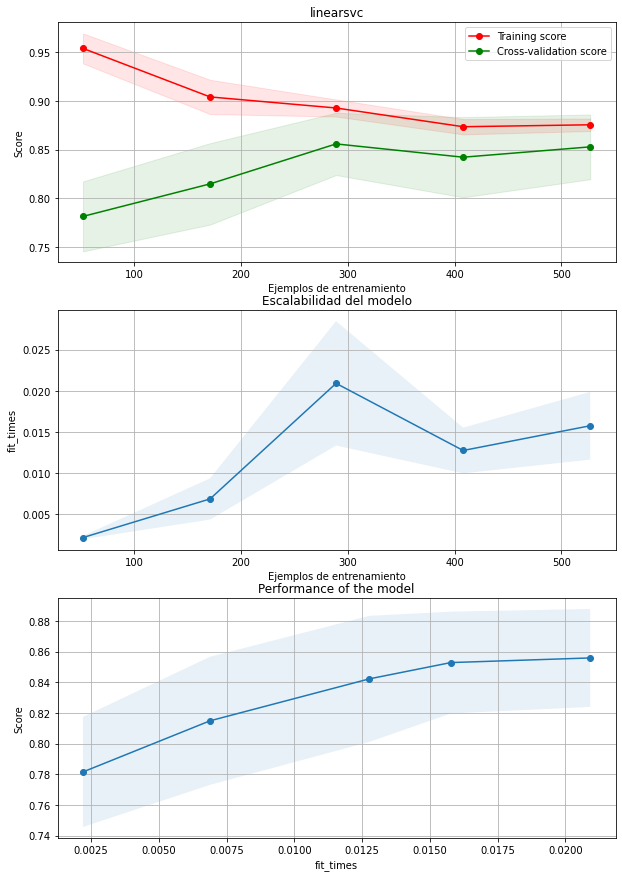

In [ ]:

#Window Size:  1240  Overlaping Fraction:  0.25  Best Accuracy:  0.9390243902439024
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

X_train, X_test, X_val, y_train, y_test, y_val = get_ttv(0.25,1240)
#best_model = make_pipeline(StandardScaler(),LinearSVC(C=1,
#                                                      intercept_scaling=0.1,
#                                                      loss='hinge',
#                                                      max_iter=100000,
#                                                      random_state=0,
#                                                      tol=1e-05))


plot_learning_curve(the_best_model,"linearsvc",X_train,y_train,axes=axes,ylim=None,cv=None,
                n_jobs=None,scoring=None,train_sizes=np.linspace(0.1, 1.0, 5))
best_model.fit(X_train, y_train)       
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


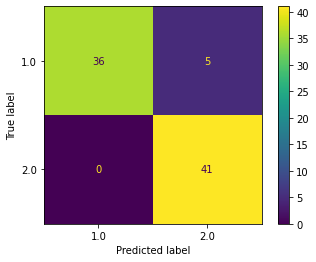

In [ ]:
plot_confusion_matrix(the_best_model,X_test,y_test)
plt.show()

In [ ]:
y_pred = the_best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       1.00      0.88      0.94        41
         2.0       0.89      1.00      0.94        41

    accuracy                           0.94        82
   macro avg       0.95      0.94      0.94        82
weighted avg       0.95      0.94      0.94        82

